<a href="https://colab.research.google.com/github/infung/MachineLearning_practice/blob/main/weather_prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [334]:
import pandas as pd

df = pd.read_csv('./weather_prediction_dataset.csv', usecols=['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_sunshine', 'BASEL_humidity', 'BASEL_precipitation', 'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_temp_mean', 'BASEL_temp_min', 'BASEL_temp_max'])
df.columns = ['Date', 'Month', 'Cloud', 'Sunshine', 'Humidity', 'Precipitation', 'Pressure', 'Global_radiation', 'MeanTemp', 'MinTemp', 'MaxTemp']
df['Date_int'] = df['Date']
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              3654 non-null   datetime64[ns]
 1   Month             3654 non-null   int64         
 2   Cloud             3654 non-null   int64         
 3   Sunshine          3654 non-null   float64       
 4   Humidity          3654 non-null   float64       
 5   Precipitation     3654 non-null   float64       
 6   Pressure          3654 non-null   float64       
 7   Global_radiation  3654 non-null   float64       
 8   MeanTemp          3654 non-null   float64       
 9   MinTemp           3654 non-null   float64       
 10  MaxTemp           3654 non-null   float64       
 11  Date_int          3654 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(3)
memory usage: 342.7 KB
None


In [335]:
df.isnull().sum()
df.head()

,Date,Month,Cloud,Sunshine,Humidity,Precipitation,Pressure,Global_radiation,MeanTemp,MinTemp,MaxTemp,Date_int
0,2000-01-01,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9,20000101
1,2000-01-02,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8,20000102
2,2000-01-03,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8,20000103
3,2000-01-04,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,7.5,20000104
4,2000-01-05,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,8.6,20000105


In [270]:
# from sklearn.preprocessing import LabelEncoder

# columns_to_convert = df.select_dtypes(include=['object']).columns
# print(columns_to_convert) # Wind direction ('N', 'S', 'E', 'W') are oridinal relationship

# # use label encoder for oridinal variable (for nominal , use one-hot encoding (get_dummies))
# label_encoder = LabelEncoder()
# df[columns_to_convert] = df[columns_to_convert].apply(lambda x: label_encoder.fit_transform(x))

# df.head()

In [271]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.linear_model import BayesianRidge, Ridge
# import numpy as np

# impute_estimator = BayesianRidge()
# imputer_num = IterativeImputer(missing_values=np.nan, random_state=0, estimator=impute_estimator, max_iter=25, tol=1e-3)

# df['Min_Temp'] = imputer_num.fit_transform(df[['Min_Temp']])


In [273]:
# import seaborn as sns

# sns.heatmap(df.isnull(), cbar=False, cmap='viridis')


<ipython-input-336-e48260383802>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

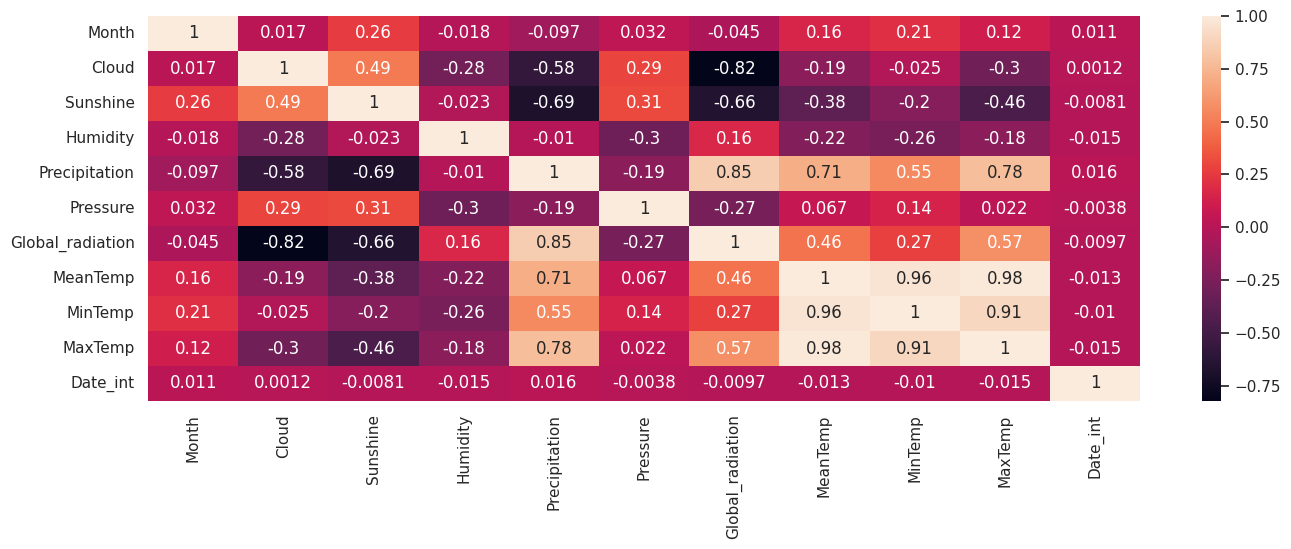

In [336]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (16,5))
sns.heatmap(df.corr(),annot=True)

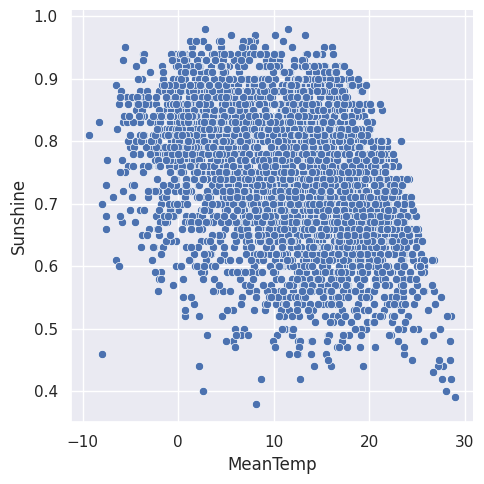

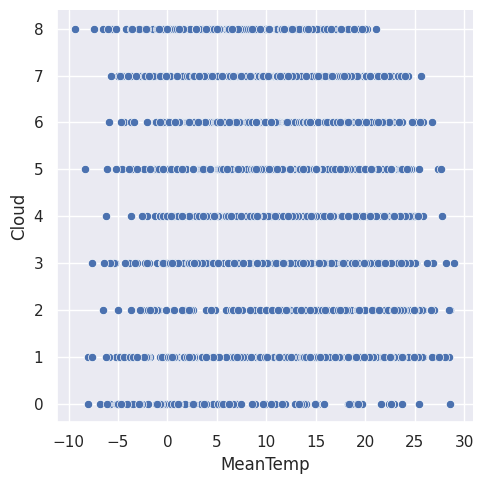

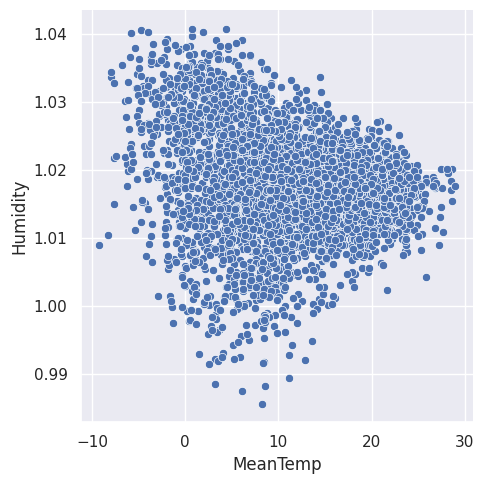

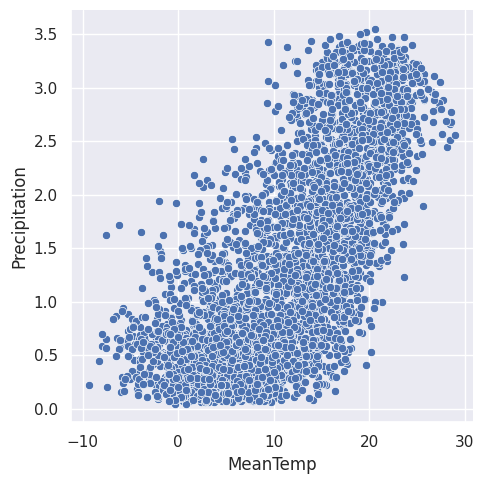

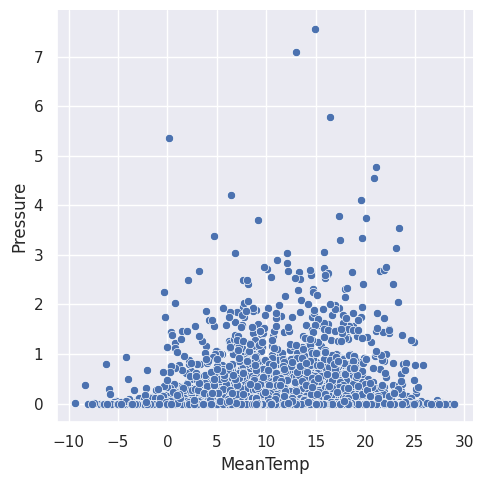

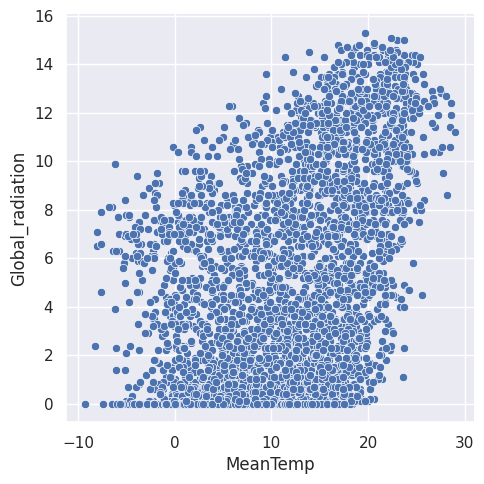

In [337]:
sns.relplot(x='MeanTemp',y='Sunshine',data=df)
sns.relplot(x='MeanTemp',y='Cloud',data=df)
sns.relplot(x='MeanTemp',y='Humidity',data=df)
sns.relplot(x='MeanTemp',y='Precipitation',data=df)
sns.relplot(x='MeanTemp',y='Pressure',data=df)
sns.relplot(x='MeanTemp',y='Global_radiation',data=df)

In [338]:
df = df.drop(['Cloud', 'Sunshine', 'Humidity', 'MeanTemp'], axis=1)
df.head()

,Date,Month,Precipitation,Pressure,Global_radiation,MinTemp,MaxTemp,Date_int
0,2000-01-01,1,0.20,0.03,0.0,1.6,3.9,20000101
1,2000-01-02,1,0.25,0.00,0.0,2.7,4.8,20000102
2,2000-01-03,1,0.50,0.00,3.7,0.1,4.8,20000103
3,2000-01-04,1,0.63,0.35,6.9,0.5,7.5,20000104
4,2000-01-05,1,0.51,0.07,3.7,3.8,8.6,20000105


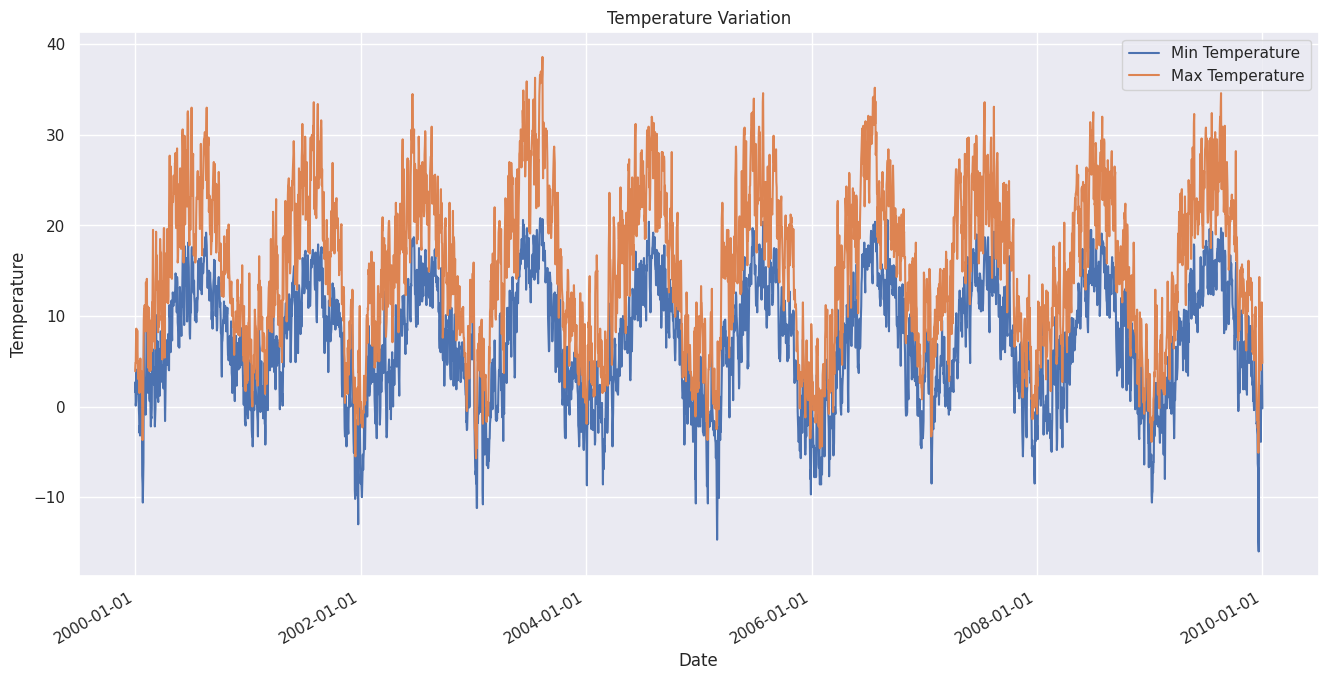

In [339]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

sns.set(style="darkgrid")
sns.lineplot(x='Date', y='MinTemp', data=df, label='Min Temperature')
sns.lineplot(x='Date', y='MaxTemp', data=df, label='Max Temperature')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Variation')
plt.legend()

date_format = plt.matplotlib.dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()

plt.show()

In [343]:
# Reshape the training and testing sets for LSTM
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np

data_x = df[['MinTemp', 'MaxTemp', 'Precipitation', 'Pressure', 'Global_radiation', 'Month', 'Date_int']]
data_y = df[['MinTemp', 'MaxTemp']]

scaler = MinMaxScaler()
scaled_data_x = scaler.fit_transform(data_x)
scaled_data_y = scaler.fit_transform(data_y)

today_temp = scaled_data_x[-1]
print(today_temp)

X = scaled_data_x[0:-1] # yesterday
X = np.array(X)
y = scaled_data_y[1:] # today
y = np.array(y)

train_size = int(len(X) * 0.8) # 80% for training, 20% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

seq_length = 1
X_train_tensor = torch.reshape(X_train_tensor, (-1, seq_length, X_train_tensor.shape[1]))
X_test_tensor = torch.reshape(X_test_tensor, (-1, seq_length, X_test_tensor.shape[1]))

print(X_train_tensor.shape) # [2922, 1, 7]
print(X_test_tensor.shape) # [731, 1, 7]
print(y_train_tensor.shape) # [2922, 2]

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

[0.42934783 0.23702032 0.00857143 0.07397622 0.         0.
 1.        ]
torch.Size([2922, 1, 7])
torch.Size([731, 1, 7])
torch.Size([2922, 2])


In [344]:
import torch
from torch import nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.num_layer = 2
        self.hidden_size = hidden_size
        self.num_directions = 2  # For bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=self.num_layer, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layer*self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layer*self.num_directions, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [347]:
input_size = 7  # Number of features (MinTemp and MaxTemp)
hidden_size = 256 # 2923 training samples, the hidden_size should be 128 to 256
output_size = 2  # Output two values: MinTemp and MaxTemp

model = LSTM(input_size, hidden_size, output_size)

# Model Training Preparation
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTM(
  (lstm): LSTM(7, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)

In [348]:
# Model Training
test_losses = []
train_losses = []
test_prediction = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        outputs = model(batch_x.float())
        loss = criterion(outputs, batch_y.float())
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
    # Train loss
    train_losses.append(epoch_loss / len(train_loader))
    # Test loss
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor.float())
    test_losses.append(test_loss.item())
    test_prediction = test_outputs.detach().numpy() # only take the last round

    print(f"Epoch {epoch+1}: Train Loss: {epoch_loss / len(train_loader)}, Test Loss: {test_loss}")

Epoch 1: Train Loss: 0.037522023817038404, Test Loss: 0.00798049196600914
Epoch 2: Train Loss: 0.005001297552118321, Test Loss: 0.004440391901880503
Epoch 3: Train Loss: 0.004173436930970005, Test Loss: 0.004122703801840544
Epoch 4: Train Loss: 0.004077977181979171, Test Loss: 0.004156904295086861
Epoch 5: Train Loss: 0.004093707268349017, Test Loss: 0.003996486309915781
Epoch 6: Train Loss: 0.003949457716257514, Test Loss: 0.003917168825864792
Epoch 7: Train Loss: 0.0042670912048576965, Test Loss: 0.0038896738551557064
Epoch 8: Train Loss: 0.004017451421215968, Test Loss: 0.004492949694395065
Epoch 9: Train Loss: 0.0040458452928325405, Test Loss: 0.00393023993819952
Epoch 10: Train Loss: 0.004112642822766919, Test Loss: 0.004065783694386482
Epoch 11: Train Loss: 0.003957061329856515, Test Loss: 0.003861459670588374
Epoch 12: Train Loss: 0.00406936758056121, Test Loss: 0.0053306156769394875
Epoch 13: Train Loss: 0.004023155711247059, Test Loss: 0.004070679657161236
Epoch 14: Train Loss

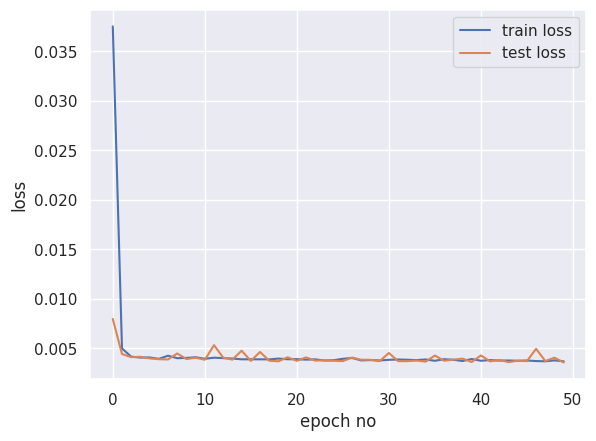

In [349]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

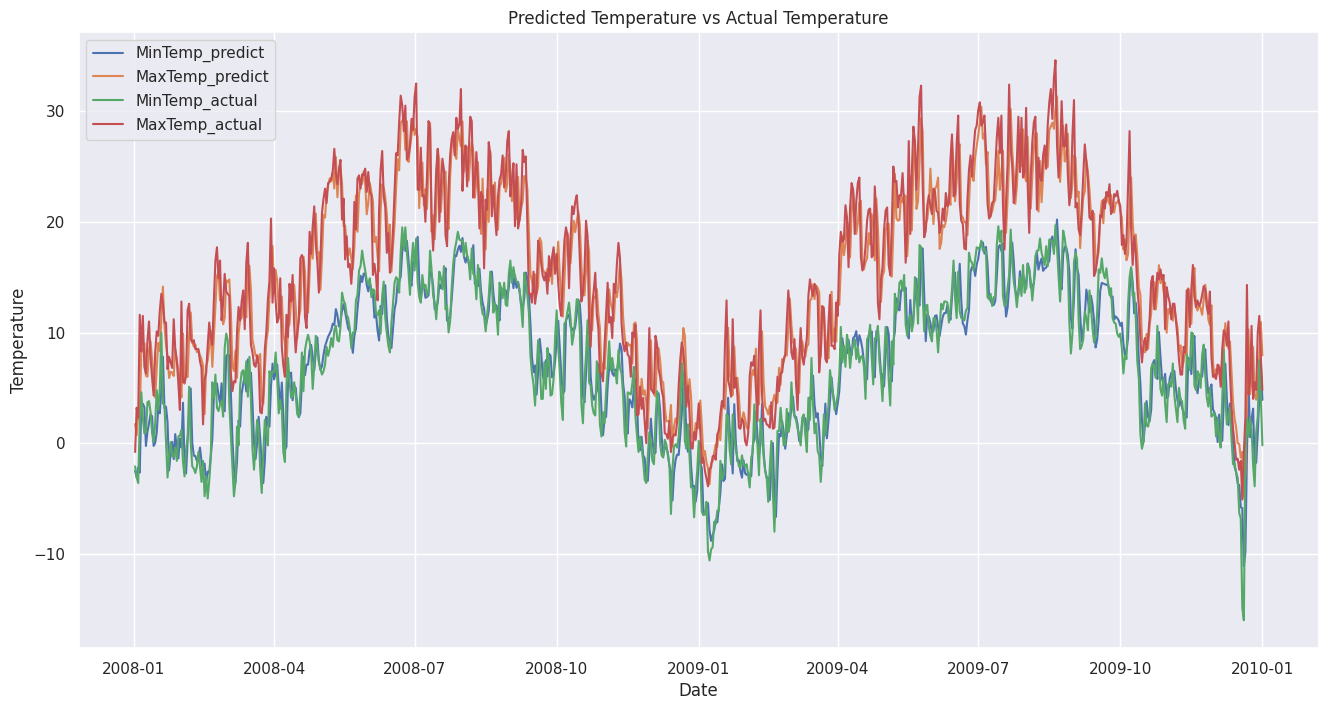

In [350]:
# Use the inverse_transform method to obtain the original values
inverse_test_prediction = scaler.inverse_transform(test_prediction)
inverse_y_test = scaler.inverse_transform(y_test)

plot_len = len(inverse_test_prediction)
date = df['Date'][-plot_len:]

x1, y1 = zip(*inverse_test_prediction)
x2, y2 = zip(*inverse_y_test)

plot_df = pd.DataFrame()
plot_df['Date'] = date
plot_df['MinTemp_predict'] = x1
plot_df['MaxTemp_predict'] = y1
plot_df['MinTemp_actual'] = x2
plot_df['MaxTemp_actual'] = y2

plt.figure(figsize=(16, 8))
sns.lineplot(data=plot_df, x='Date', y='MinTemp_predict', label='MinTemp_predict')
sns.lineplot(data=plot_df, x='Date', y='MaxTemp_predict', label='MaxTemp_predict')
sns.lineplot(data=plot_df, x='Date', y='MinTemp_actual', label='MinTemp_actual')
sns.lineplot(data=plot_df, x='Date', y='MaxTemp_actual', label='MaxTemp_actual')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Predicted Temperature vs Actual Temperature')
plt.legend()
plt.show()

Square Error of the Naive Approach is 7.858
Square Error of the LSTM Approach is 6.084


Text(0.5, 1.0, 'Distribution of Differences')

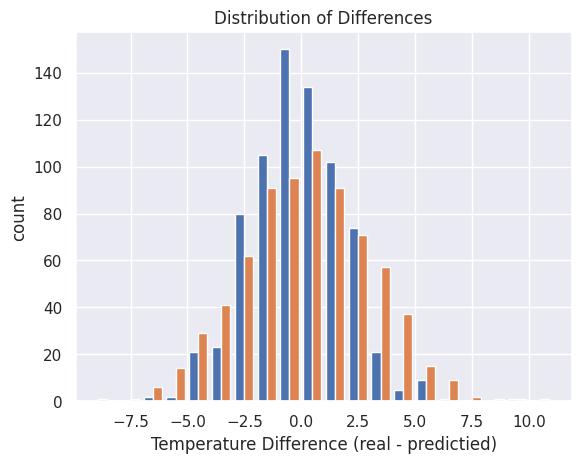

In [351]:
# Calculate the MSE
# The benchmark
weather_naive = df[['Date', 'MinTemp', 'MaxTemp']].copy(deep=True)
weather_naive['Prev_MinTemp'] = df['MinTemp'].shift(1)
weather_naive['Prev_MaxTemp'] = df['MaxTemp'].shift(1)
weather_naive.drop([0], inplace=True)
weather_naive['Diff_MinTemp'] = weather_naive['MinTemp'] - weather_naive['Prev_MinTemp']
weather_naive['Diff_MaxTemp'] = weather_naive['MaxTemp'] - weather_naive['Prev_MaxTemp']
weather_naive['Square_Error'] = (weather_naive['Diff_MinTemp'] ** 2 + weather_naive['Diff_MaxTemp'] ** 2)/2

square_error = weather_naive['Square_Error'].mean()
print(f'Square Error of the Naive Approach is {square_error:.3f}')

# The MSE of LSTM model
weather_LSTM = pd.DataFrame()
weather_LSTM['Pred_MinTemp'] = x1
weather_LSTM['Pred_MaxTemp'] = y1
weather_LSTM['Act_MinTemp'] = x2
weather_LSTM['Act_MaxTemp'] = y2
weather_LSTM.drop([0], inplace=True)
weather_LSTM['Diff_MinTemp'] = weather_LSTM['Act_MinTemp'] - weather_LSTM['Pred_MinTemp']
weather_LSTM['Diff_MaxTemp'] = weather_LSTM['Act_MaxTemp'] - weather_LSTM['Pred_MaxTemp']
weather_LSTM['Square_Error'] = (weather_LSTM['Diff_MinTemp'] ** 2 + weather_LSTM['Diff_MaxTemp'] ** 2)/2

square_error = weather_LSTM['Square_Error'].mean()
print(f'Square Error of the LSTM Approach is {square_error:.3f}')

plt.hist(inverse_y_test-inverse_test_prediction, bins=20)
plt.xlabel('Temperature Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')

In [370]:
# Predict the next days temperature
print(today_temp) # [0.42934783 0.23702032 0.00857143 0.07397622 0. 0. 1.]
today_temp_tensor = torch.tensor([today_temp]).float().to(device)
today_temp_tensor = torch.reshape(today_temp_tensor, (1, -1, today_temp_tensor.shape[1]))

model.eval() # Set the model to evaluation mode

future_days = 1
future_temp = []
for epoch in range(future_days):
  with torch.no_grad():
    predicted_output = model(today_temp_tensor)
    future_temp.append(predicted_output.detach().numpy())
    today_temp_tensor = torch.reshape(predicted_output, (1, -1, predicted_output.shape[1]))

print(future_temp)

[0.42934783 0.23702032 0.00857143 0.07397622 0.         0.
 1.        ]
[array([[0.4358323 , 0.21827948]], dtype=float32)]


In [371]:
import datetime

future_temp = np.concatenate(future_temp, axis=0)
future_temp = scaler.inverse_transform(future_temp)

plot_df = pd.DataFrame()
start_date1 = datetime.datetime(2009, 12, 20)
end_date1 = datetime.datetime(2010, 1, 1)
date_range1 = [start_date1 + datetime.timedelta(days=x) for x in range((end_date1 - start_date1).days + 1)]

start_date2 = datetime.datetime(2010, 1, 2)
end_date2 = datetime.datetime(2010, 1, 2)
date_range2 = [start_date2 + datetime.timedelta(days=x) for x in range((end_date2 - start_date2).days + 1)]

(0.03862834,)
(3.969781,)


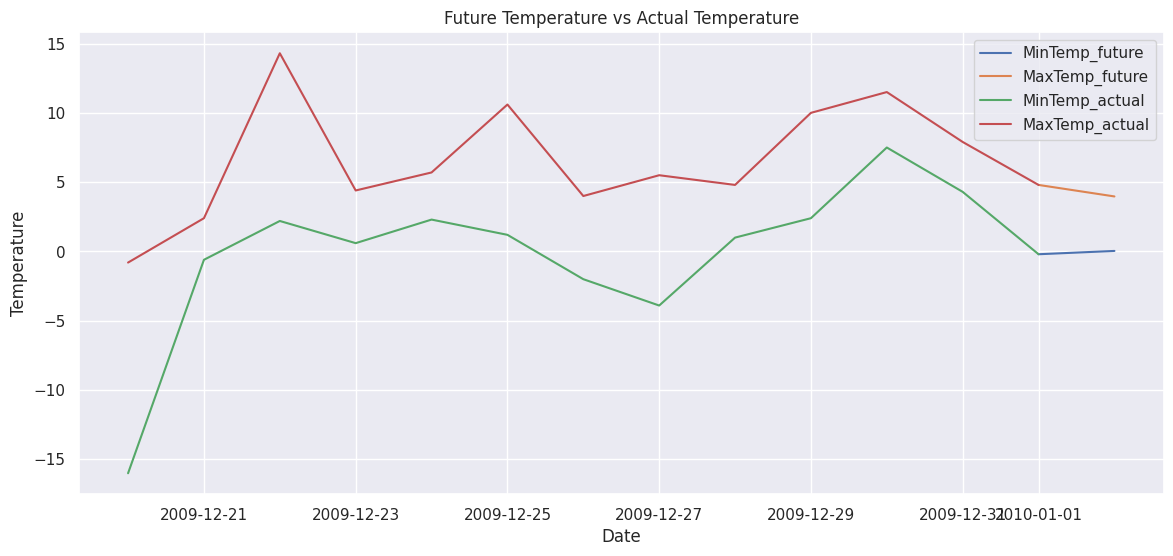

In [372]:
plot_df = pd.DataFrame()

x3, y3 = zip(*future_temp)
print(x3)
print(y3)

# Assign values to the DataFrame
plot_df['Date'] = date_range1 + date_range2
plot_df['MinTemp_future'] = [None] * (len(date_range1)-1) + list(x2[-1:]) + list(x3)
plot_df['MaxTemp_future'] = [None] * (len(date_range1)-1) + list(y2[-1:]) + list(y3)
plot_df['MinTemp_actual'] = list(x2[-len(date_range1):]) + [None] * len(date_range2)
plot_df['MaxTemp_actual'] = list(y2[-len(date_range1):]) + [None] * len(date_range2)

# Plot the lines
plt.figure(figsize=(14, 6))
sns.lineplot(data=plot_df, x='Date', y='MinTemp_future', label='MinTemp_future')
sns.lineplot(data=plot_df, x='Date', y='MaxTemp_future', label='MaxTemp_future')
sns.lineplot(data=plot_df, x='Date', y='MinTemp_actual', label='MinTemp_actual')
sns.lineplot(data=plot_df, x='Date', y='MaxTemp_actual', label='MaxTemp_actual')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Future Temperature vs Actual Temperature')
plt.legend()